In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 9
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 294
vmax = 3000
vmin = 1900
w_diffuse = [(1.55, 1.55), (1.55, 1.55, 1.55, 1.55, 1.8)]
wgt = [(0.3, 0.4), (0.5, 0.6, 0.7, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

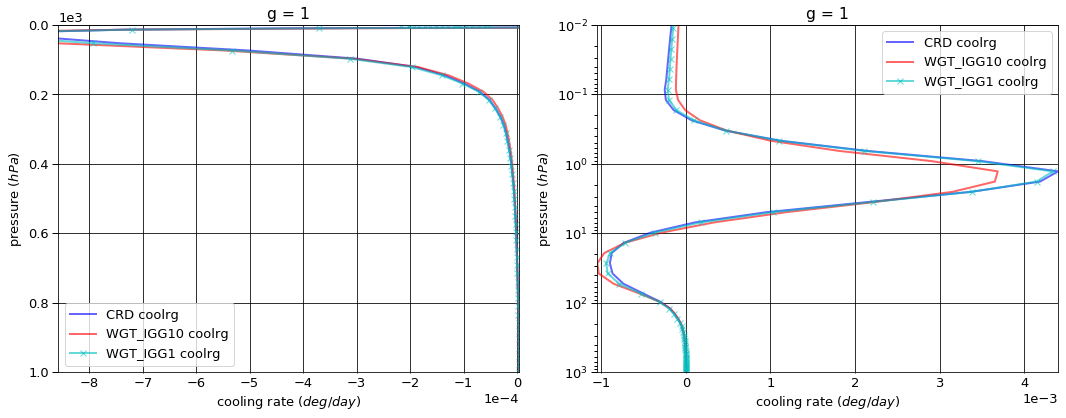

# Figure: cooling rate g-group 2

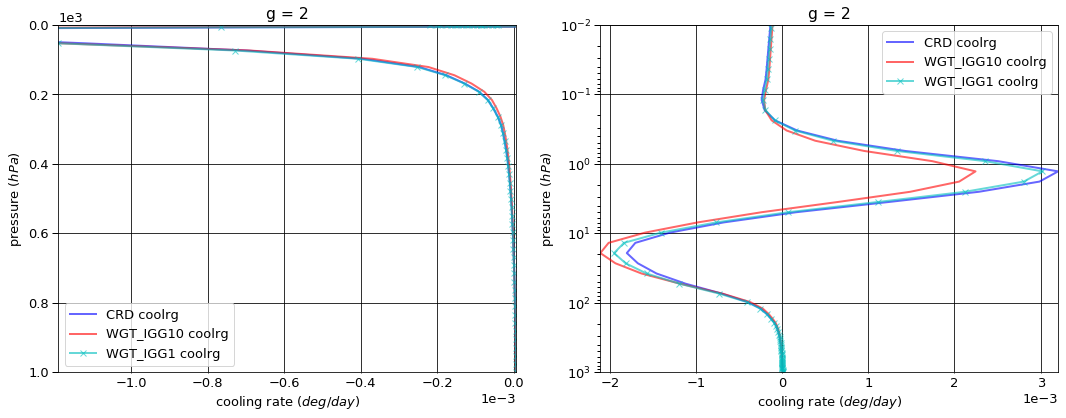

# Figure: cooling rate g-group 3

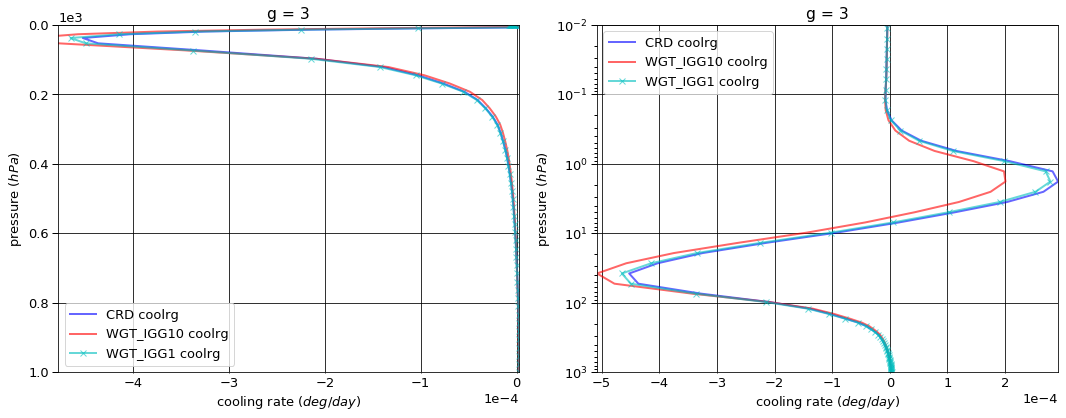

# Figure: cooling rate g-group 4

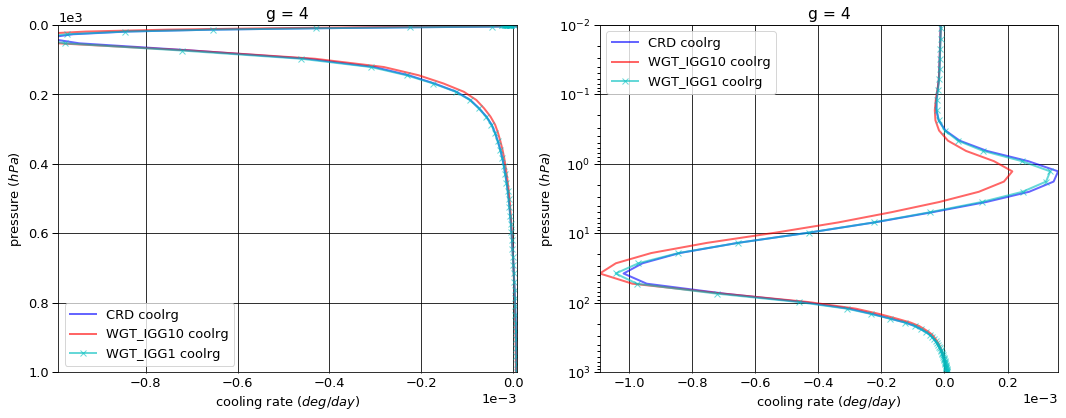

# Figure: cooling rate g-group 5

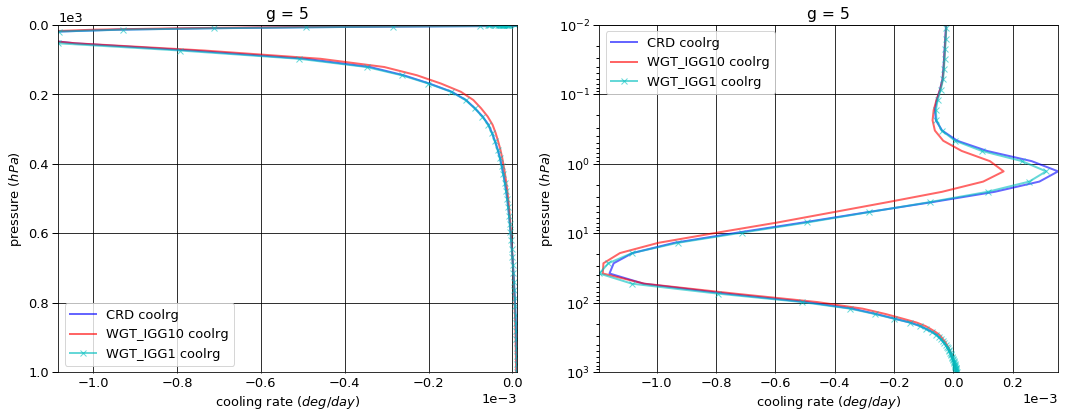

# Figure: cooling rate g-group 6

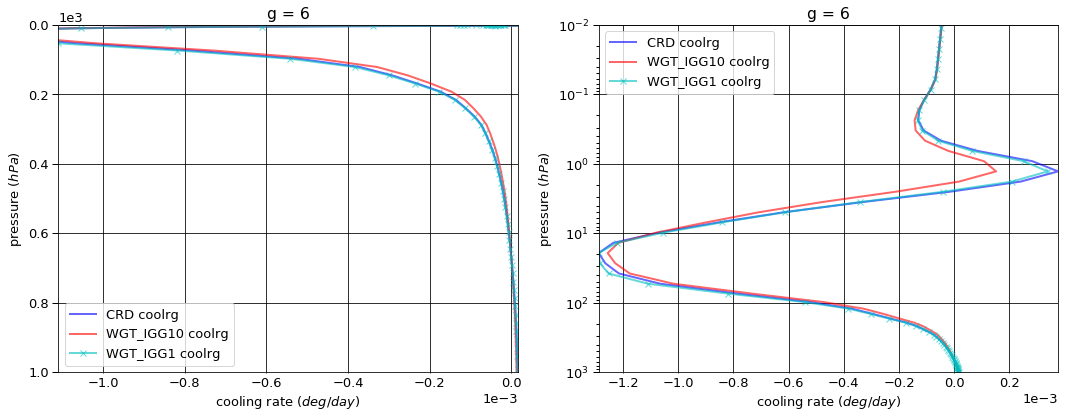

# Figure: cooling rate g-group 7

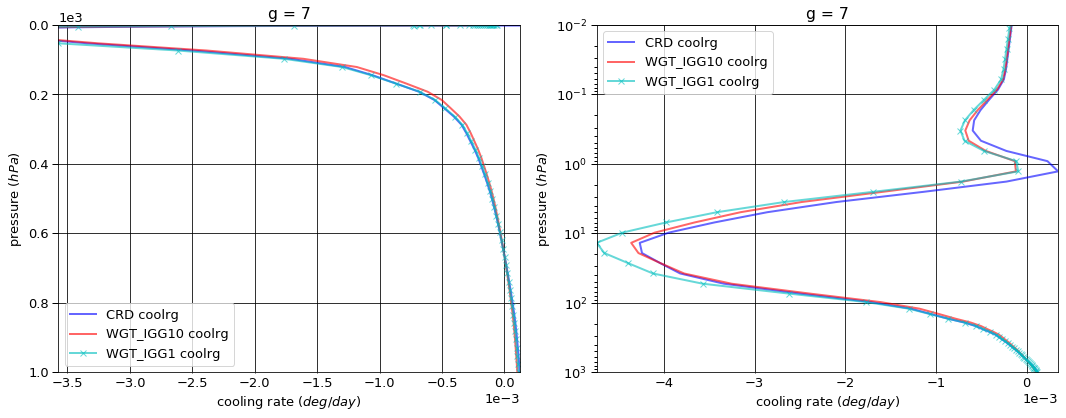

# Figure: cooling rate g-group total

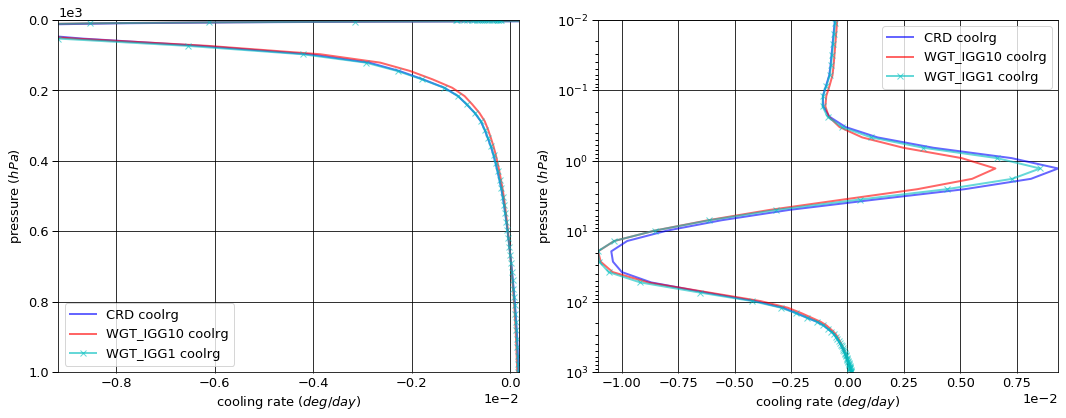

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002172  0.000000 -0.002172
  1013.0   76    -0.010624  0.000681 -0.009943
2 0.0      1     -0.008302  0.000000 -0.008302
  1013.0   76    -0.023755  0.001306 -0.022449
3 0.0      1     -0.002245  0.000000 -0.002245
  1013.0   76    -0.008069  0.000445 -0.007625
4 0.0      1     -0.010365  0.000000 -0.010365
  1013.0   76    -0.023884  0.001091 -0.022793
5 0.0      1     -0.023511  0.000000 -0.023511
  1013.0   76    -0.039520  0.001429 -0.038091
6 0.0      1     -0.046943  0.000000 -0.046943
  1013.0   76    -0.065207  0.001912 -0.063295
7 0.0      1     -6.387461  0.000000 -6.387461
  1013.0   76    -6.454392  0.010360 -6.444032


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001824  0.000000 -0.001824
  1013.0   76    -0.010880  0.000629 -0.010251
2 0.0      1     -0.007765  0.000000 -0.007765
  1013.0   76    -0.024441  0.001291 -0.023150
3 0.0      1     -0.002180  0.000000 -0.002180
  1013.0   76    -0.008260  0.000413 -0.007846
4 0.0      1     -0.010926  0.000000 -0.010926
  1013.0   76    -0.024483  0.000984 -0.023499
5 0.0      1     -0.025256  0.000000 -0.025256
  1013.0   76    -0.040600  0.001246 -0.039354
6 0.0      1     -0.050237  0.000000 -0.050237
  1013.0   76    -0.067109  0.001626 -0.065484
7 0.0      1     -6.386250  0.000000 -6.386250
  1013.0   76    -6.449679  0.008945 -6.440735


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002033  0.000000 -0.002033
  1013.0   76    -0.010880  0.000681 -0.010199
2 0.0      1     -0.007999  0.000000 -0.007999
  1013.0   76    -0.024441  0.001326 -0.023115
3 0.0      1     -0.002261  0.000000 -0.002261
  1013.0   76    -0.008260  0.000449 -0.007811
4 0.0      1     -0.010659  0.000000 -0.010659
  1013.0   76    -0.024483  0.001088 -0.023395
5 0.0      1     -0.024257  0.000000 -0.024257
  1013.0   76    -0.040600  0.001418 -0.039182
6 0.0      1     -0.048399  0.000000 -0.048399
  1013.0   76    -0.067109  0.001902 -0.065207
7 0.0      1     -6.380098  0.000000 -6.380098
  1013.0   76    -6.449679  0.009840 -6.439840


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000349  0.000000  0.000349
  1013.0   76    -0.000256 -0.000052 -0.000308
2 0.0      1      0.000537  0.000000  0.000537
  1013.0   76    -0.000686 -0.000015 -0.000701
3 0.0      1      0.000065  0.000000  0.000065
  1013.0   76    -0.000190 -0.000031 -0.000222
4 0.0      1     -0.000562  0.000000 -0.000562
  1013.0   76    -0.000599 -0.000107 -0.000706
5 0.0      1     -0.001745  0.000000 -0.001745
  1013.0   76    -0.001080 -0.000183 -0.001263
6 0.0      1     -0.003295  0.000000 -0.003295
  1013.0   76    -0.001902 -0.000287 -0.002189
7 0.0      1      0.001211  0.000000  0.001211
  1013.0   76     0.004713 -0.001415  0.003298


WGT_IGG1 - CRD


flug          fldg     fnetg
g pressure level                                  
1 0.0      1      0.000139  0.000000e+00  0.000139
  1013.0   76    -0.000256 -4.954900e-07 -0.000256
2 0.0      1      0.000303  0.000000e+00  0.000303
  1013.0   76    -0.000686  2.011250e-05 -0.000666
3 0.0      1     -0.000016  0.000000e+00 -0.000016
  1013.0   76    -0.000190  3.853180e-06 -0.000187
4 0.0      1     -0.000294  0.000000e+00 -0.000294
  1013.0   76    -0.000599 -3.056000e-06 -0.000602
5 0.0      1     -0.000746  0.000000e+00 -0.000746
  1013.0   76    -0.001080 -1.153370e-05 -0.001091
6 0.0      1     -0.001456  0.000000e+00 -0.001456
  1013.0   76    -0.001902 -1.045350e-05 -0.001913
7 0.0      1      0.007363  0.000000e+00  0.007363
  1013.0   76     0.004713 -5.200948e-04  0.004193

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000061
  1001.112500 75     0.000004
2 0.000312    1     -0.000046
  1001.112500 75     0.000006
3 0.000312    1     -0.000001
  1001.112500 75     0.000003
4 0.000312    1     -0.000004
  1001.112500 75     0.000008
5 0.000312    1     -0.000008
  1001.112500 75     0.000011
6 0.000312    1     -0.000015
  1001.112500 75     0.000016
7 0.000312    1     -0.000053
  1001.112500 75     0.000124


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.000032
  1001.112500 75     0.000003
2 0.000312    1     -0.000038
  1001.112500 75     0.000005
3 0.000312    1     -0.000001
  1001.112500 75     0.000002
4 0.000312    1     -0.000004
  1001.112500 75     0.000006
5 0.000312    1     -0.000008
  1001.112500 75     0.000009
6 0.000312    1     -0.000015
  1001.112500 75     0.000013
7 0.000312    1     -0.000054
  1001.112500 75     0.000104


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.000053
  1001.112500 75     0.000004
2 0.000312    1     -0.000042
  1001.112500 75     0.000006
3 0.000312    1     -0.000001
  1001.112500 75     0.000003
4 0.000312    1     -0.000004
  1001.112500 75     0.000008
5 0.000312    1     -0.000008
  1001.112500 75     0.000011
6 0.000312    1     -0.000015
  1001.112500 75     0.000016
7 0.000312    1     -0.000059
  1001.112500 75     0.000114


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.906153e-05
  1001.112500 75    -6.390346e-07
2 0.000312    1      8.757606e-06
  1001.112500 75    -1.077434e-06
3 0.000312    1      6.940260e-08
  1001.112500 75    -5.131192e-07
4 0.000312    1      5.548860e-08
  1001.112500 75    -1.358415e-06
5 0.000312    1      2.862368e-07
  1001.112500 75    -1.963185e-06
6 0.000312    1      3.702360e-07
  1001.112500 75    -2.907021e-06
7 0.000312    1     -1.352418e-06
  1001.112500 75    -1.998321e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      8.169433e-06
  1001.112500 75     9.578980e-08
2 0.000312    1      4.307810e-06
  1001.112500 75     1.201881e-07
3 0.000312    1     -1.057100e-09
  1001.112500 75     5.711120e-08
4 0.000312    1      2.169608e-07
  1001.112500 75     1.269626e-07
5 0.000312    1      4.698097e-07
  1001.112500 75     1.772980e-07
6 0.000312    1      2.615000e-09
  1001.112500 75     2.971080e-07
7 0.000312    1     -6.087905e-06
  1001.112500 75    -9.314580e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.480999,0.000000,-6.480999
1013.0,76,-6.625452,0.017224,-6.608229



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.484439,0.000000,-6.484439
1013.0,76,-6.625452,0.015133,-6.610319



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.475706,0.000000,-6.475706
1013.0,76,-6.625452,0.016702,-6.608750



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.439851e-03,0.00000,-0.00344
1013.0,76,-5.450000e-08,-0.00209,-0.00209



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,5.293552e-03,0.000000,0.005294
1013.0,76,-5.450000e-08,-0.000522,-0.000522


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000189
1001.112500,75,0.000170



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000152
1001.112500,75,0.000142



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000182
1001.112500,75,0.000162



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000037
1001.112500,75,-0.000028



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000007
1001.112500,75,-0.000008


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000836,0.001642
2,0.001836,0.003689
3,0.000636,0.001247
4,0.001873,0.003695
5,0.003073,0.006128
6,0.005036,0.010129
7,0.986709,0.973470


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.916117e-19
2,1.000385e-19
3,1.130539e-19
4,6.351783e-20
5,3.568666e-20
6,2.005008e-20
7,1.234350e-27


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.916117e-19,NaN,0.000836,0.001642,0.000836,0.001642,1.0
2,1.000385e-19,2.554533e-01,0.001836,0.003689,0.002673,0.005331,1.0
3,1.130539e-19,1.130104e+00,0.000636,0.001247,0.003309,0.006578,50.0
4,6.351783e-20,5.618369e-01,0.001873,0.003695,0.005182,0.010273,50.0
5,3.568666e-20,5.618369e-01,0.003073,0.006128,0.008255,0.016401,50.0
6,2.005008e-20,5.618369e-01,0.005036,0.010129,0.013291,0.026530,50.0
7,1.234350e-27,6.156334e-08,0.986709,0.973470,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
